<a href="https://colab.research.google.com/github/HumaSatti/Depression-Detection-By-ML-Deep-Learning-Model/blob/main/Depression_Data_Preprocessing_%26_Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'nurse-stress-prediction-wearable-sensors:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4110234%2F7125235%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240821%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240821T210205Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D2a0a4ef82f8b068df830cb86da76d09f7261a5ac00a88b15d61b8d69fe374c92b7a8fa9ec71ddca798838010b0d2ff6d91e9028a19afdb4d18ad2d2db1001247f04cd155d71dbaaa9d5c129777bcc5d4ee1b75fcbaa9f1d19d67eb035b04e31df9ca1f89a16b266bf8ca664fb2bc3e93d025c2112496a9dc60dbb637020c63a0a6dd8e68c1af7f969db25eafa23fd85c424107e143071d4f85ca0f918b38d4f79aa2e397f04fa8be6df3829d55f66a91762c4a4c37a804aaa578b115e38c35d15edfb1416183c3185730d58560b87ca7fae6b1e5fe1ff824dfd81a8d3e21ab3d23556033f42747d05e697004000a1432a446c12465196cea54a16f75e612b7da'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 79877492 bytes downloaded
Downloaded and uncompressed: nurse-stress-prediction-wearable-sensors
Data source import complete.


In [2]:
import sys
import platform
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


Read Dataset

In [3]:
df = pd.read_csv('/kaggle/input/nurse-stress-prediction-wearable-sensors/merged_data.csv', parse_dates=['datetime'])
df.head()

<ipython-input-3-26b2a78fa34c>:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/kaggle/input/nurse-stress-prediction-wearable-sensors/merged_data.csv', parse_dates=['datetime'])


,X,Y,Z,EDA,HR,TEMP,id,datetime,label
0,-13.0,-61.0,5.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.000000000,2.0
1,-20.0,-69.0,-3.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.031249920,2.0
2,-31.0,-78.0,-15.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.062500096,2.0
3,-47.0,-65.0,-38.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.093750016,2.0
4,-67.0,-57.0,-53.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.124999936,2.0


In [4]:
df


,X,Y,Z,EDA,HR,TEMP,id,datetime,label
0,-13.0,-61.0,5.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.000000000,2.0
1,-20.0,-69.0,-3.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.031249920,2.0
2,-31.0,-78.0,-15.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.062500096,2.0
3,-47.0,-65.0,-38.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.093750016,2.0
4,-67.0,-57.0,-53.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.124999936,2.0
...,...,...,...,...,...,...,...,...,...
11509046,-16.0,-56.0,24.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.875000064,2.0
11509047,-8.0,-50.0,27.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.906249984,2.0
11509048,-28.0,-36.0,28.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.937499904,2.0
11509049,-29.0,-29.0,30.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.968750080,2.0


DaTa Profiling

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11509051 entries, 0 to 11509050
Data columns (total 9 columns):
 #   Column    Dtype         
---  ------    -----         
 0   X         float64       
 1   Y         float64       
 2   Z         float64       
 3   EDA       float64       
 4   HR        float64       
 5   TEMP      float64       
 6   id        object        
 7   datetime  datetime64[ns]
 8   label     float64       
dtypes: datetime64[ns](1), float64(7), object(1)
memory usage: 790.3+ MB


In [6]:
df.head()

,X,Y,Z,EDA,HR,TEMP,id,datetime,label
0,-13.0,-61.0,5.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.000000000,2.0
1,-20.0,-69.0,-3.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.031249920,2.0
2,-31.0,-78.0,-15.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.062500096,2.0
3,-47.0,-65.0,-38.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.093750016,2.0
4,-67.0,-57.0,-53.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.124999936,2.0


In [7]:
df.isna().sum()

,0
X,0
Y,0
Z,0
EDA,0
HR,0
TEMP,0
id,0
datetime,0
label,0


In [8]:
num_duplicated_rows = df.duplicated().sum()
num_duplicated_rows

105606

In [9]:
df.describe()

,X,Y,Z,EDA,HR,TEMP,datetime,label
count,1.150905e+07,1.150905e+07,1.150905e+07,1.150905e+07,1.150905e+07,1.150905e+07,11509051,1.150905e+07
mean,-2.823775e+01,-9.091032e-01,2.382449e+01,3.502127e+00,8.576090e+01,3.223435e+01,2020-08-01 00:55:33.359851264,1.554202e+00
min,-1.280000e+02,-1.280000e+02,-1.280000e+02,0.000000e+00,5.100000e+01,2.409000e+01,2020-04-14 22:31:00,0.000000e+00
25%,-5.200000e+01,-1.900000e+01,4.000000e+00,2.242060e-01,7.672000e+01,3.019000e+01,2020-06-25 20:39:14.390625024,1.000000e+00
50%,-3.300000e+01,1.000000e+00,2.500000e+01,1.157407e+00,8.390000e+01,3.257000e+01,2020-07-06 18:24:36.750000128,2.000000e+00
75%,-1.400000e+01,1.700000e+01,4.900000e+01,4.077436e+00,9.310000e+01,3.425000e+01,2020-08-06 20:39:26.953124864,2.000000e+00
max,1.270000e+02,1.270000e+02,1.270000e+02,5.976071e+01,1.802300e+02,3.659000e+01,2020-12-13 08:01:00,2.000000e+00
std,3.142310e+01,3.343382e+01,2.985317e+01,5.656541e+00,1.419642e+01,2.260516e+00,NaN,7.891827e-01


In [11]:
# Group the data by ID and get the row with the maximum temperature for each group
max_temp_rows = df.loc[df.groupby("id")["TEMP"].idxmax()]

# Print the details of the row with the maximum temperature for each group
print(max_temp_rows)

             X     Y      Z        EDA      HR   TEMP  id            datetime  \
144005   -57.0   4.0  -15.0   3.075611   77.07  35.50  15 2020-07-22 20:34:00   
4574030  -64.0   7.0    4.0   1.662621   83.83  36.23  83 2020-11-02 05:17:57   
6057489  -66.0 -31.0  -29.0  18.849356   79.98  36.57  94 2020-05-11 00:49:52   
300650     7.0 -35.0   75.0   1.811155   93.52  32.61  15 2020-07-31 20:08:35   
317291   -22.0 -44.0  127.0  20.073507   85.88  36.59  5C 2020-04-14 22:35:15   
1869983  -47.0  25.0   40.0   1.948249   78.42  32.71  6B 2020-06-29 18:22:58   
2000610  -27.0   4.0   58.0   0.515300  108.03  34.25  6D 2020-07-16 14:49:00   
3206510  -53.0 -23.0  -12.0   3.388557   93.53  36.13  7A 2020-04-22 22:46:04   
4096807   -7.0  35.0   52.0   0.961276   81.85  35.87  7E 2020-10-31 17:39:24   
5590236  -55.0  -9.0   11.0   2.756377   90.22  35.47  83 2020-12-12 03:10:13   
5668159  -64.0 -16.0  -18.0   1.838395  101.73  35.91  8B 2020-07-15 19:14:48   
6025584  -32.0 -41.0   37.0 

In [16]:
import matplotlib.pyplot as plt

In [17]:
import multiprocessing

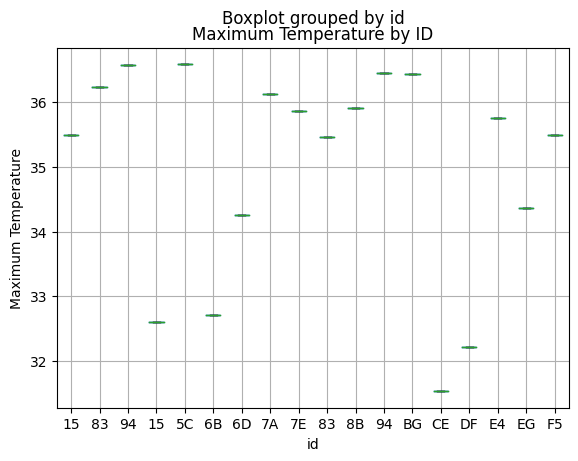

In [18]:
# Group the data by ID and calculate the maximum temperature for each group
max_temps = df.groupby("id")["TEMP"].max()

# Convert the maximum temperature data to a pandas DataFrame
max_temps_merged_df = pd.DataFrame(max_temps)

# Create a boxplot with the maximum temperature data, with the ID on the x-axis
max_temps_merged_df.boxplot(column="TEMP", by="id")

# Set the axis labels and title
plt.xlabel("id")
plt.ylabel("Maximum Temperature")
plt.title("Maximum Temperature by ID")

# Display the plot
plt.show()

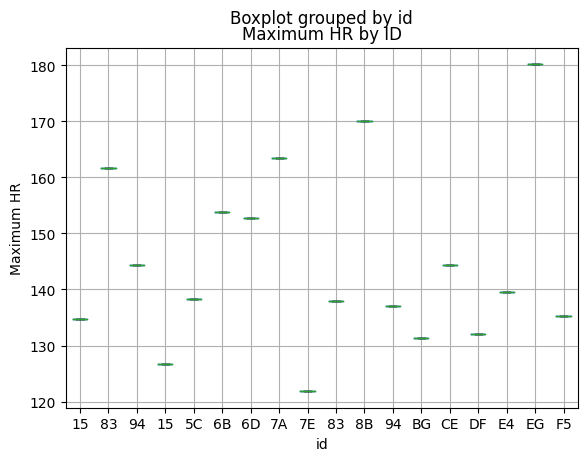

In [19]:
# Group the data by ID and calculate the maximum hr for each group
max_hr = df.groupby("id")["HR"].max()

# Convert the maximum edas data to a pandas DataFrame
max_hr_merged_df = pd.DataFrame(max_hr)

# Create a boxplot with the maximum hr data, with the ID on the x-axis
max_hr_merged_df.boxplot(column="HR", by="id")

# Set the axis labels and title
plt.xlabel("id")
plt.ylabel("Maximum HR")
plt.title("Maximum HR by ID")

# Display the plot
plt.show()

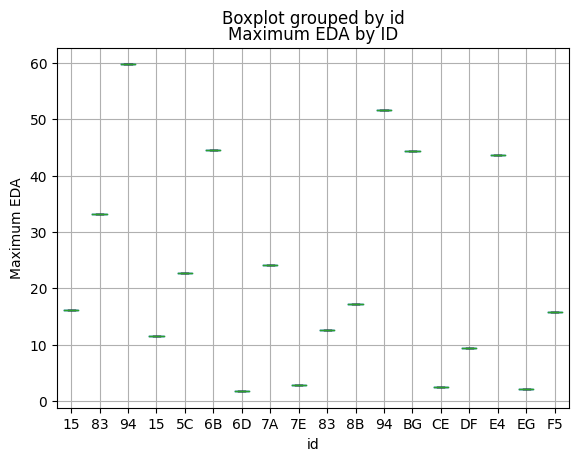

In [20]:
# Group the data by ID and calculate the maximum eda for each group
max_eda = df.groupby("id")["EDA"].max()

# Convert the maximum edas data to a pandas DataFrame
max_eda_merged_df = pd.DataFrame(max_eda)

# Create a boxplot with the maximum eda data, with the ID on the x-axis
max_eda_merged_df.boxplot(column="EDA", by="id")

# Set the axis labels and title
plt.xlabel("id")
plt.ylabel("Maximum EDA")
plt.title("Maximum EDA by ID")

# Display the plot
plt.show()

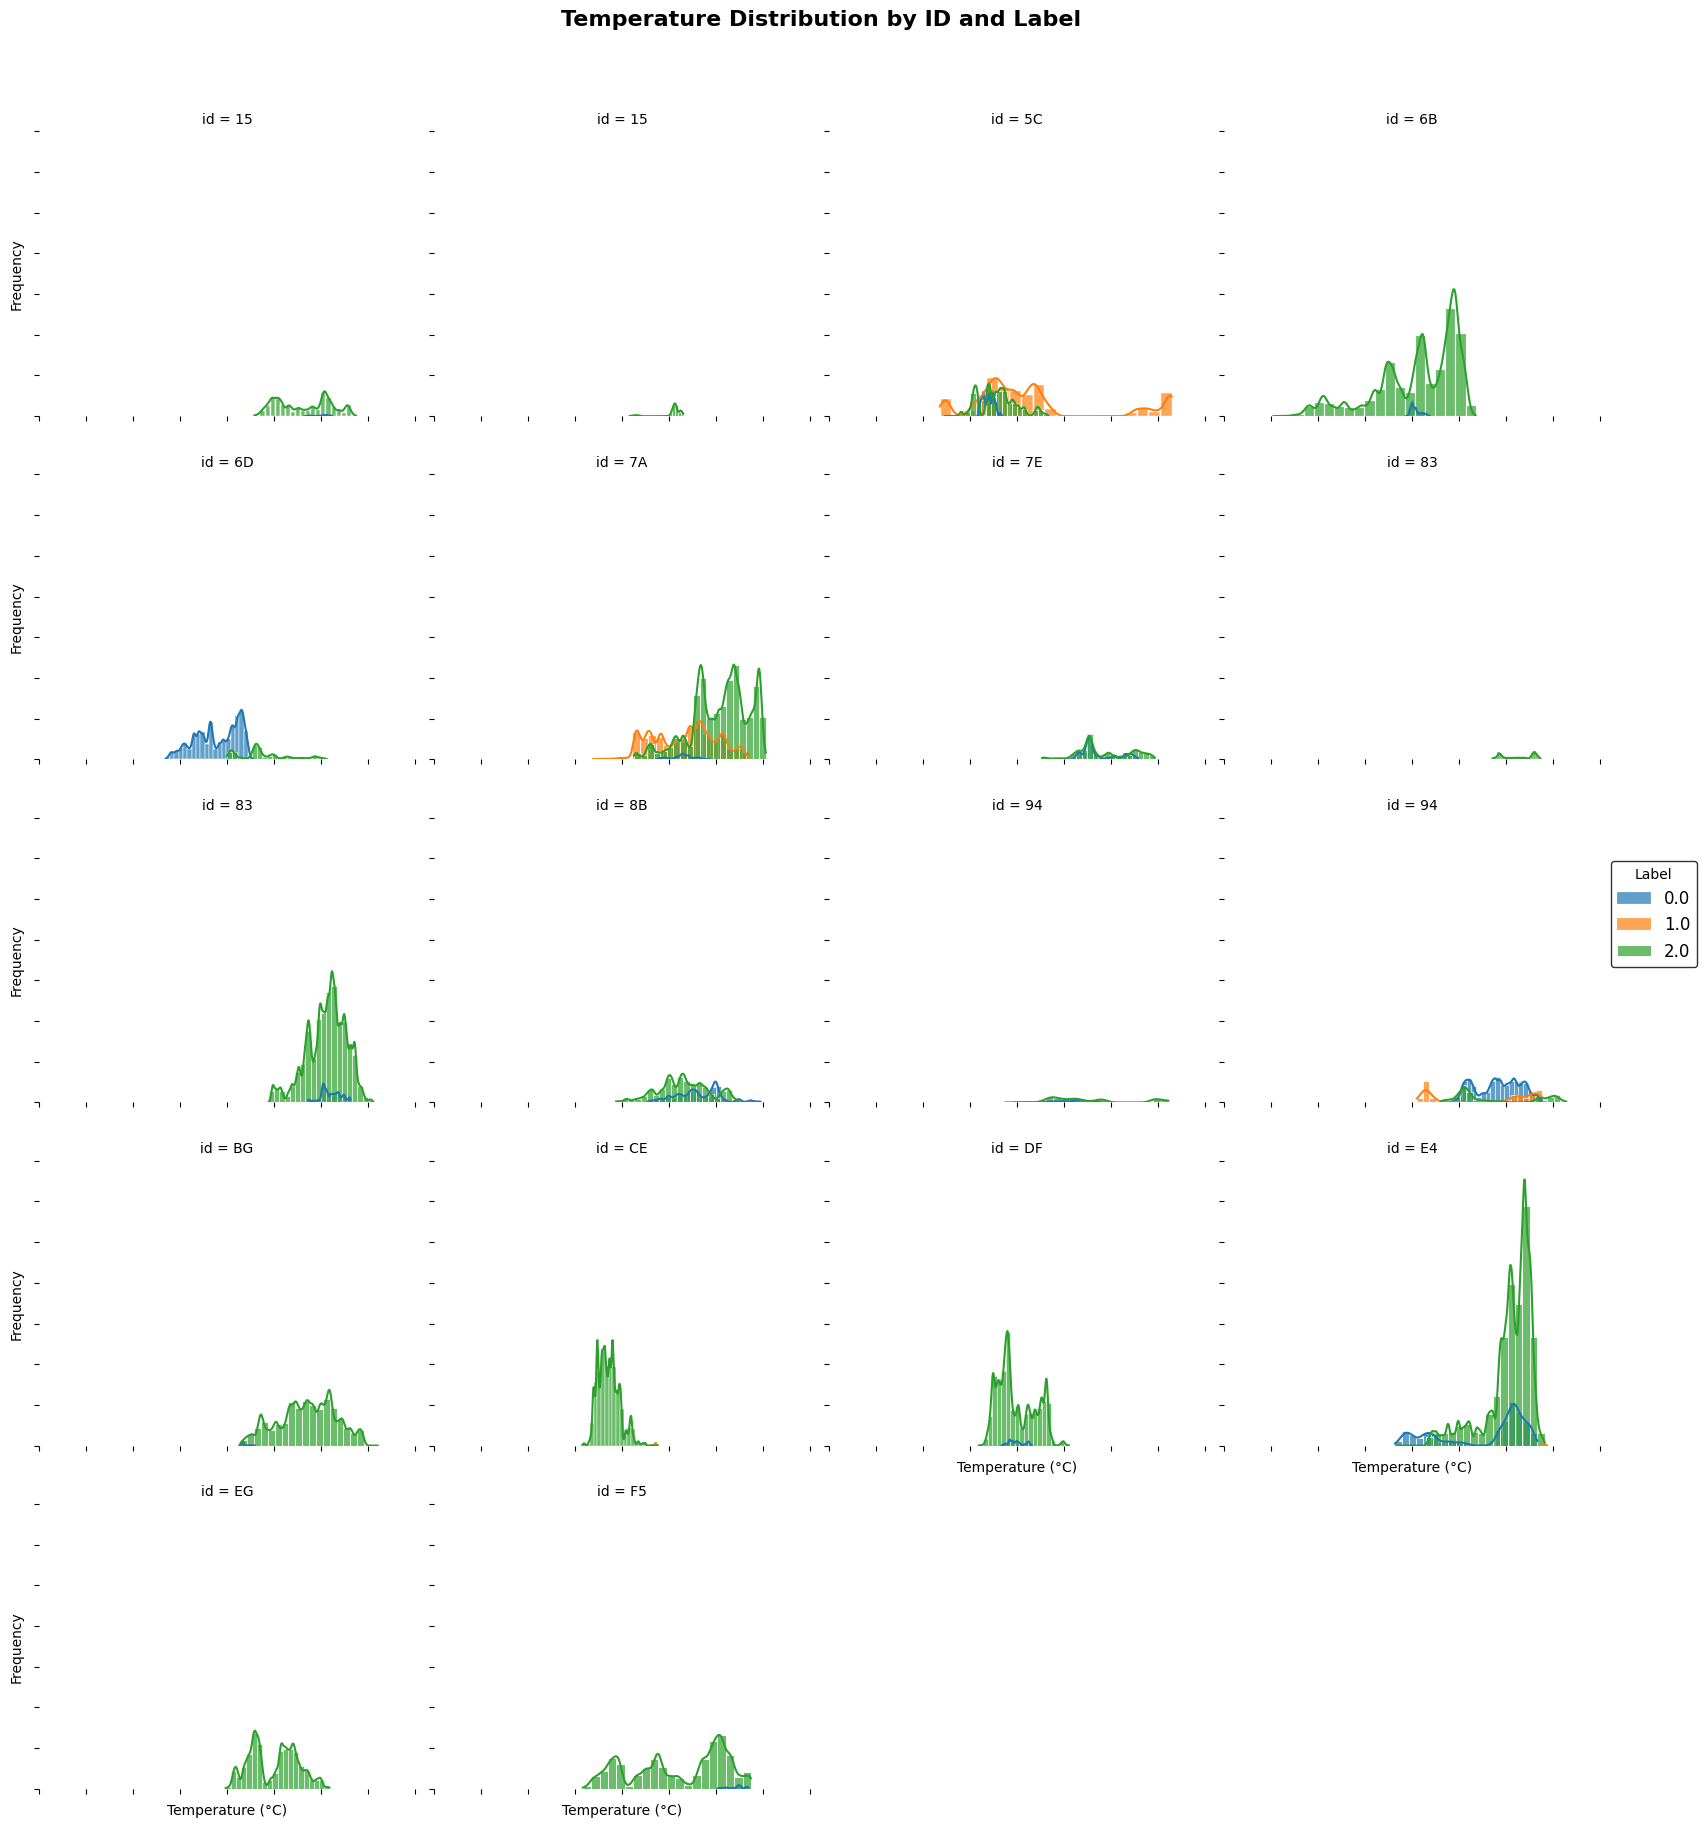

In [21]:
import seaborn as sns

# Create a FacetGrid with one plot for each combination of ID and label
g = sns.FacetGrid(df, col="id", hue="label", col_wrap=4, height=3.5, aspect=1.2)

# Map a histogram of the temperature data to each plot
g.map(sns.histplot, "TEMP", bins=20, kde=True, alpha=0.7, edgecolor='white')

# Set the axis labels and title
g.set_axis_labels("Temperature (°C)", "Frequency")
g.fig.suptitle("Temperature Distribution by ID and Label", y=1.05, fontsize=16, fontweight='bold')

# Add legend
g.add_legend(fontsize=12, title="Label", title_fontsize=14, frameon=True, edgecolor='black')

# Customize ticks and spines
g.despine(left=True, bottom=True)
g.set_xticklabels(fontsize=12)
g.set_yticklabels(fontsize=12)

# Display the plot
plt.show()

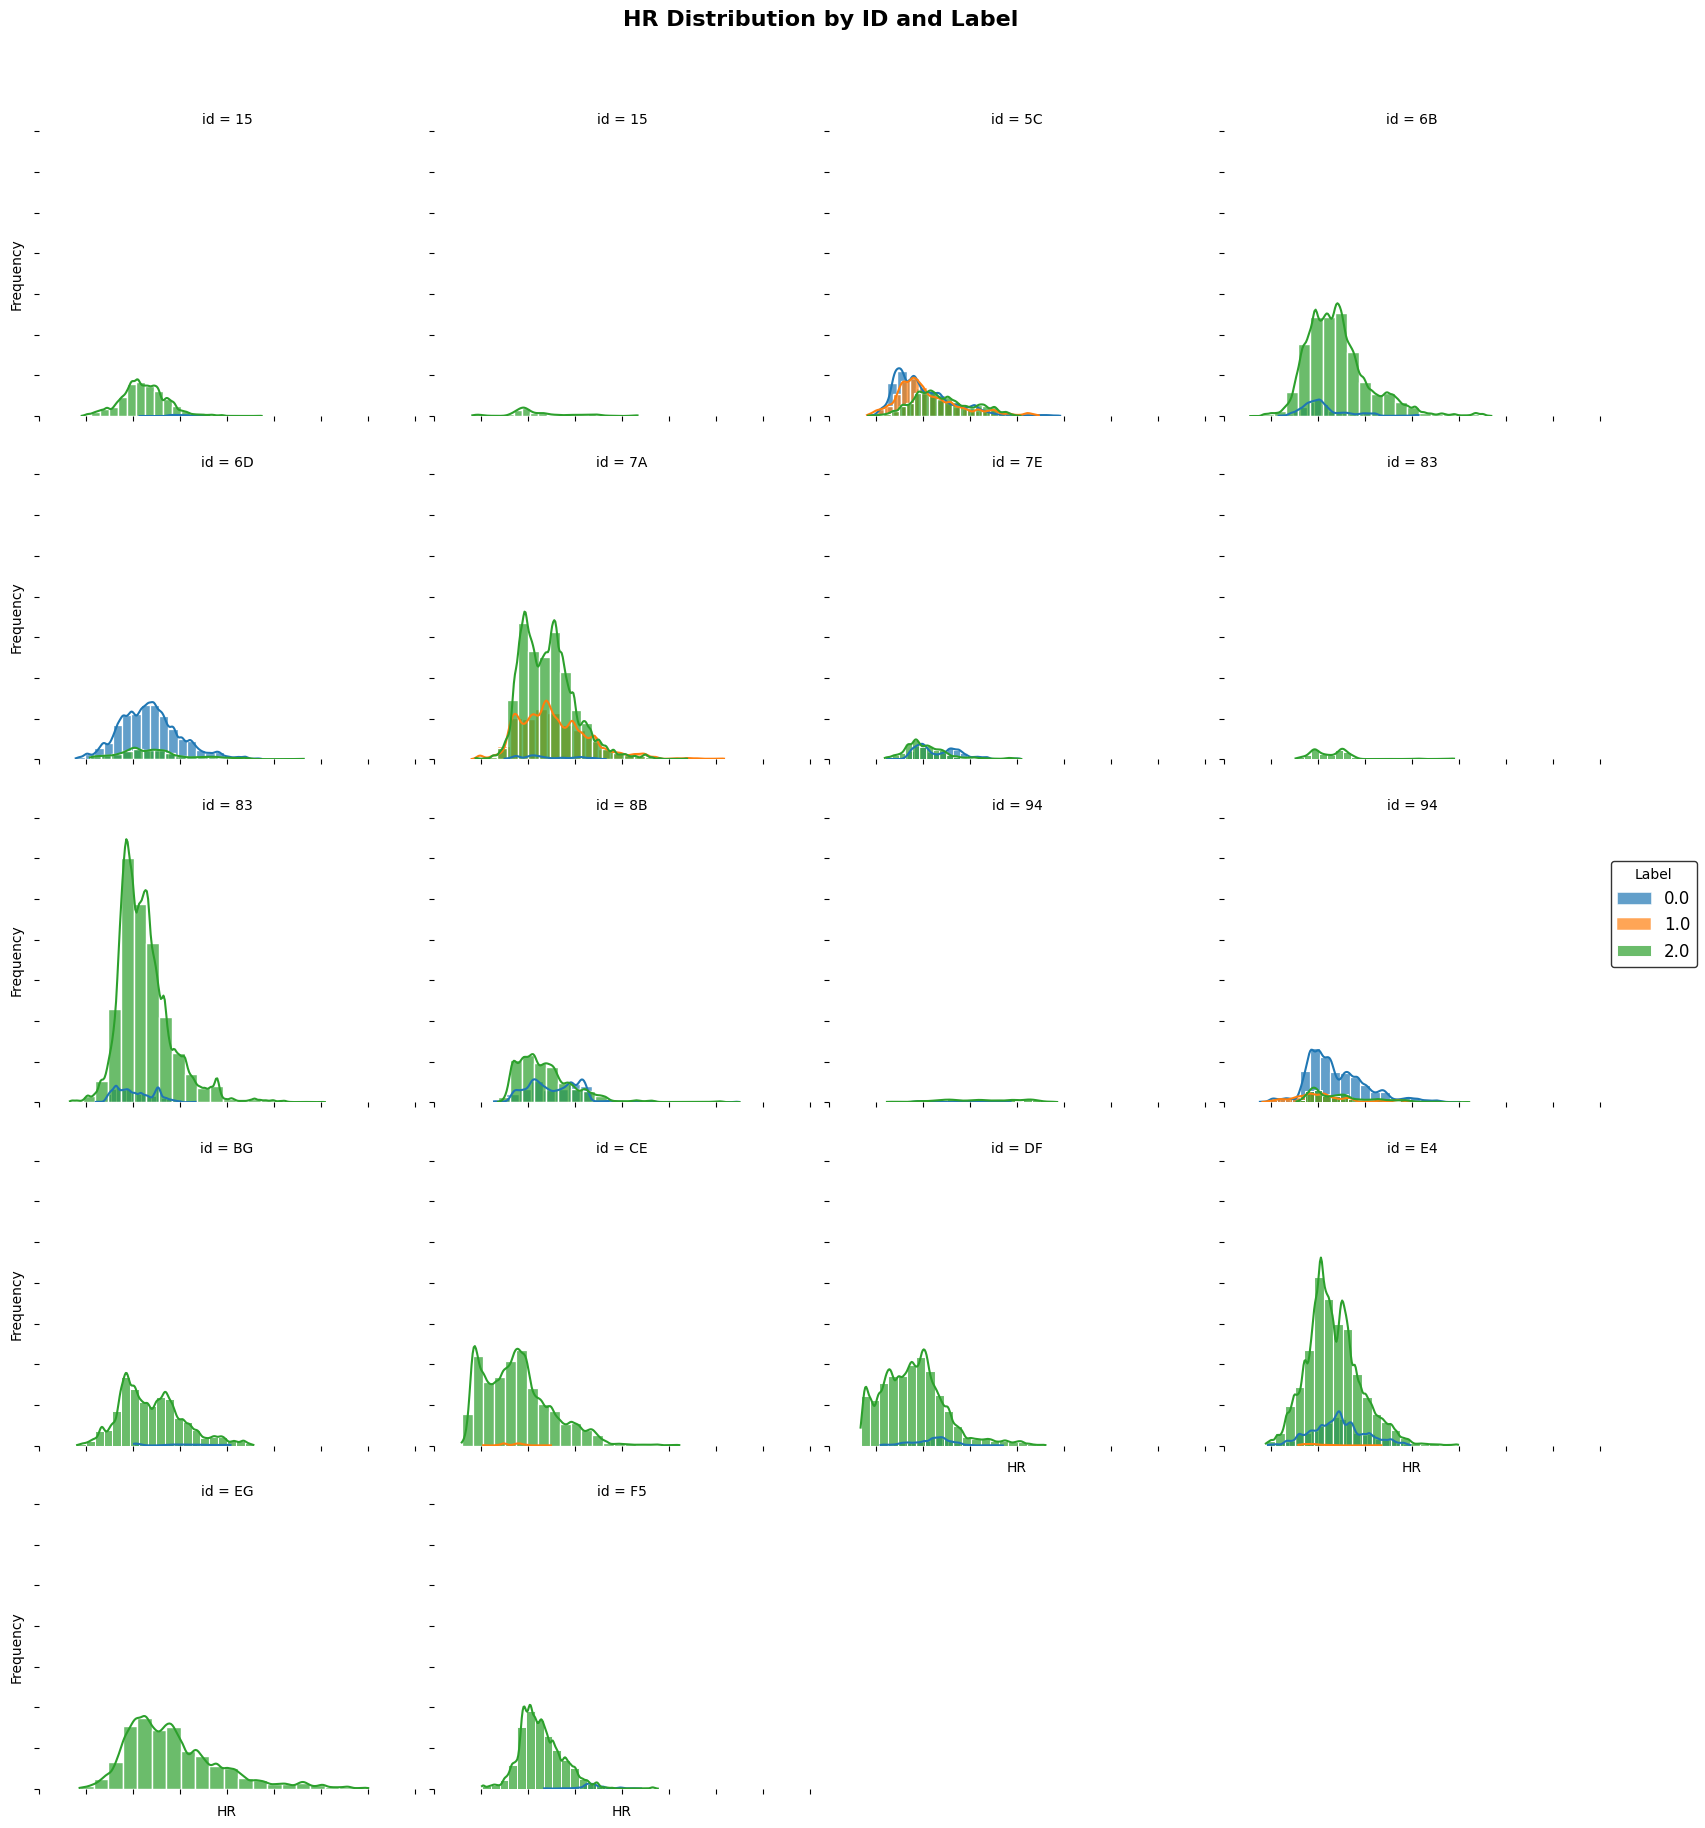

In [22]:
import seaborn as sns

# Create a FacetGrid with one plot for each combination of ID and label
g = sns.FacetGrid(df, col="id", hue="label", col_wrap=4, height=3.5, aspect=1.2)

# Map a histogram of the hr data to each plot
g.map(sns.histplot, "HR", bins=20, kde=True, alpha=0.7, edgecolor='white')

# Set the axis labels and title
g.set_axis_labels("HR", "Frequency")
g.fig.suptitle("HR Distribution by ID and Label", y=1.05, fontsize=16, fontweight='bold')

# Add legend
g.add_legend(fontsize=12, title="Label", title_fontsize=14, frameon=True, edgecolor='black')

# Customize ticks and spines
g.despine(left=True, bottom=True)
g.set_xticklabels(fontsize=12)
g.set_yticklabels(fontsize=12)

# Display the plot
plt.show()

In [23]:
import pandas as pd

# group by ID and calculate maximum temperature, HR, EDA, and stress level for each ID
temp_summary = df.groupby("id")["TEMP"].max().describe()
hr_summary = df.groupby("id")["HR"].max().describe()
eda_summary = df.groupby("id")["EDA"].max().describe()
stress_summary = df.groupby("id")["label"].max().describe()

# concatenate the data frames horizontally
summary_table = pd.concat([temp_summary, hr_summary, eda_summary, stress_summary], axis=1)

# rename the columns
summary_table.columns = ["Max Temp", "Max HR", "Max EDA", "Max Stress"]

# print the summary table
print("Summary statistics for each variable by ID:\n")
print(summary_table)

Summary statistics for each variable by ID:

        Max Temp      Max HR    Max EDA  Max Stress
count  18.000000   18.000000  18.000000        18.0
mean   35.004444  144.760556  23.089486         2.0
std     1.654563   15.806070  18.630833         0.0
min    31.530000  121.820000   1.723618         2.0
25%    34.280000  134.920000   9.989892         2.0
50%    35.625000  138.970000  16.645321         2.0
75%    36.205000  153.500000  40.951425         2.0
max    36.590000  180.230000  59.760712         2.0


In [24]:
import pandas as pd

# group by ID and calculate maximum temperature, HR, EDA, and stress level for each ID
max_temp = df.groupby("id")["TEMP"].max().rename("Max Temp")
max_hr = df.groupby("id")["HR"].max().rename("Max HR")
max_eda = df.groupby("id")["EDA"].max().rename("Max EDA")
max_stress = df.groupby("id")["label"].max().rename("Max Stress")

# concatenate the data frames horizontally
summary_table = pd.concat([max_temp, max_hr, max_eda, max_stress], axis=1)

# print the summary table for all IDs
print(summary_table)

    Max Temp  Max HR    Max EDA  Max Stress
id                                         
15     35.50  134.80  16.137552         2.0
83     36.23  161.77  33.115532         2.0
94     36.57  144.33  59.760712         2.0
15     32.61  126.62  11.462811         2.0
5C     36.59  138.37  22.777302         2.0
6B     32.71  153.75  44.583832         2.0
6D     34.25  152.75   1.723618         2.0
7A     36.13  163.50  24.167313         2.0
7E     35.87  121.82   2.766914         2.0
83     35.47  137.88  12.622820         2.0
8B     35.91  170.12  17.153090         2.0
94     36.45  137.10  51.681210         2.0
BG     36.43  131.27  44.341255         2.0
CE     31.53  144.43   2.439848         2.0
DF     32.21  132.10   9.498919         2.0
E4     35.75  139.57  43.563389         2.0
EG     34.37  180.23   2.096440         2.0
F5     35.50  135.28  15.718194         2.0


Scatter Plot

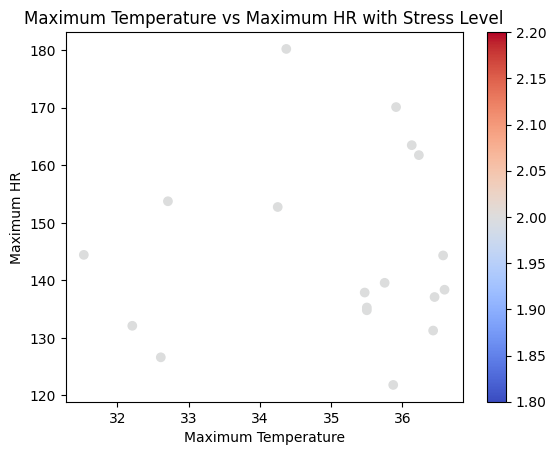

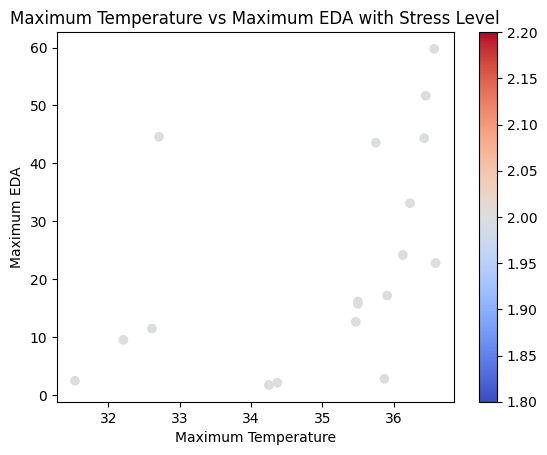

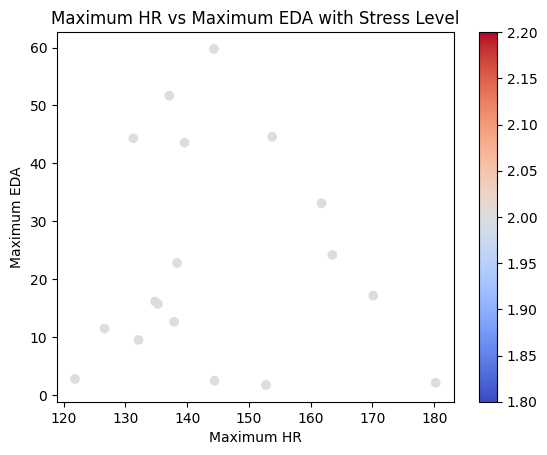

In [26]:
import matplotlib.pyplot as plt

# Get the maximum values of temperature, HR, and EDA for each individual
max_temp_rows = df.loc[df.groupby("id")["TEMP"].idxmax()]
max_hr = df.groupby("id")["HR"].max()
max_eda = df.groupby("id")["EDA"].max()

# Create scatter plots for the relationships between maximum temperature, maximum HR, and maximum EDA with the stress level as the color
plt.scatter(max_temp_rows["TEMP"], max_hr, c=df.groupby("id")["label"].max(), cmap="coolwarm")
plt.xlabel("Maximum Temperature")
plt.ylabel("Maximum HR")
plt.title("Maximum Temperature vs Maximum HR with Stress Level")
plt.colorbar()
plt.show()

plt.scatter(max_temp_rows["TEMP"], max_eda, c=df.groupby("id")["label"].max(), cmap="coolwarm")
plt.xlabel("Maximum Temperature")
plt.ylabel("Maximum EDA")
plt.title("Maximum Temperature vs Maximum EDA with Stress Level")
plt.colorbar()
plt.show()

plt.scatter(max_hr, max_eda, c=df.groupby("id")["label"].max(), cmap="coolwarm")
plt.xlabel("Maximum HR")
plt.ylabel("Maximum EDA")
plt.title("Maximum HR vs Maximum EDA with Stress Level")
plt.colorbar()
plt.show()


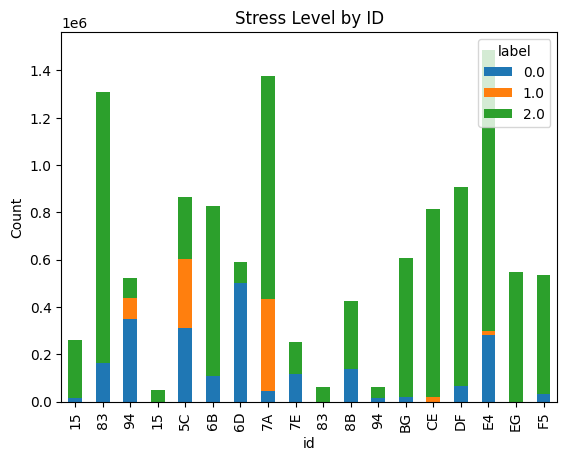

In [27]:
# Count the number of occurrences of each label for each ID
label_counts = df.groupby(['id', 'label']).size().unstack()

# Create a stacked bar chart
label_counts.plot(kind='bar', stacked=True)

# Set the axis labels and title
plt.xlabel('id')
plt.ylabel('Count')
plt.title('Stress Level by ID')

# Display the plot
plt.show()

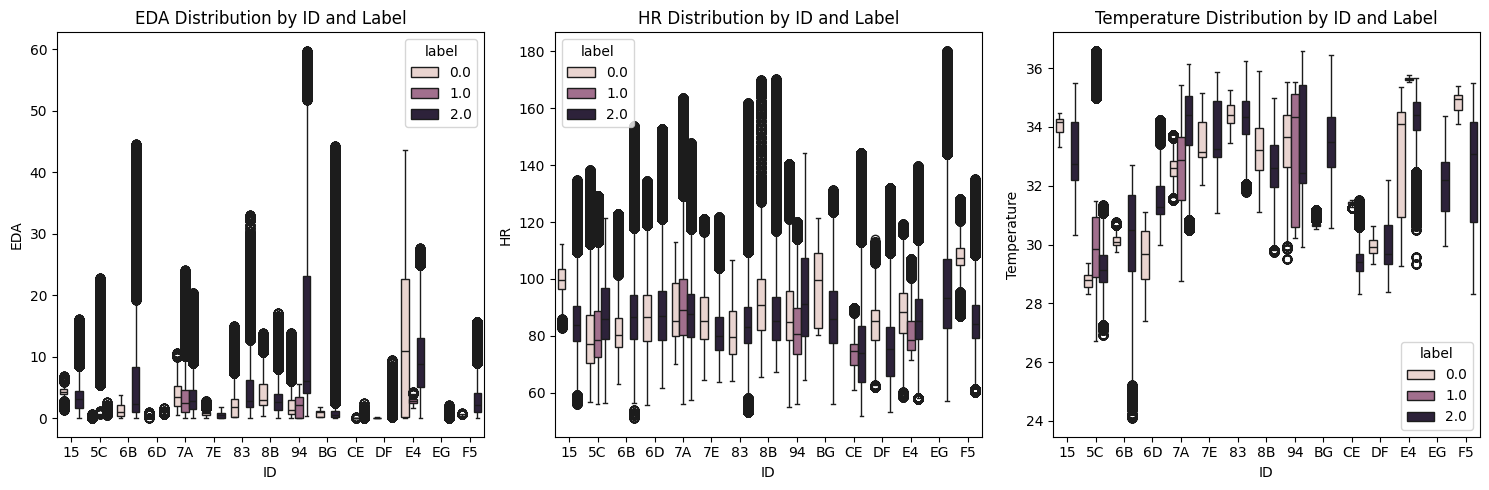

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure with 3 subplots arranged horizontally
fig, axs = plt.subplots(1, 3, figsize=(15,5))

# Create a box plot of temperature for each ID, colored by label
sns.boxplot(x="id", y="EDA", hue="label", data=df, ax=axs[0])
sns.boxplot(x="id", y="HR", hue="label", data=df, ax=axs[1])
sns.boxplot(x="id", y="TEMP", hue="label", data=df, ax=axs[2])

# Set the axis labels and title for each subplot
axs[0].set_xlabel("ID")
axs[0].set_ylabel("EDA")
axs[0].set_title("EDA Distribution by ID and Label")

axs[1].set_xlabel("ID")
axs[1].set_ylabel("HR")
axs[1].set_title("HR Distribution by ID and Label")

axs[2].set_xlabel("ID")
axs[2].set_ylabel("Temperature")
axs[2].set_title("Temperature Distribution by ID and Label")

# Adjust the layout of the subplots to avoid overlapping
plt.tight_layout()

# Display the plot
plt.show()

Selected Features

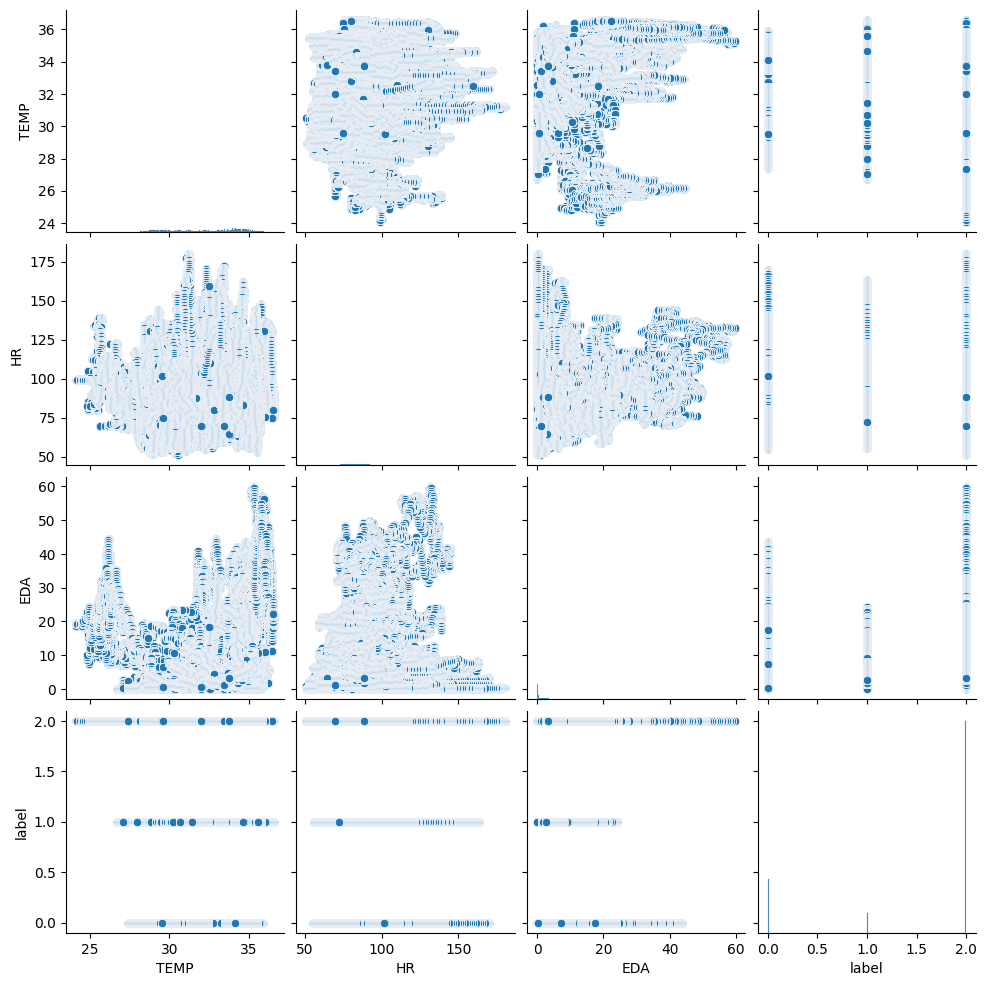

In [29]:
# Select the columns of interest
cols_of_interest = ["TEMP", "HR", "EDA", "label"]

# Create a pairplot with the selected columns
sns.pairplot(data=df[cols_of_interest])

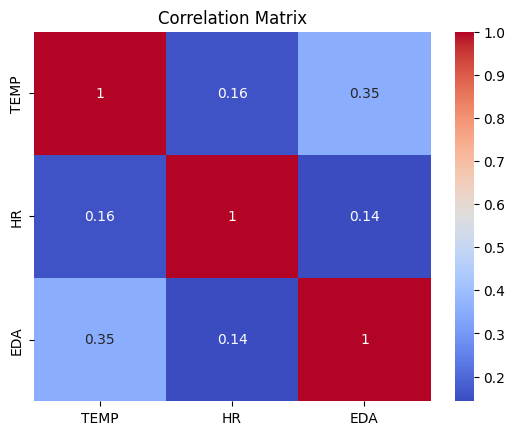

          TEMP        HR       EDA
TEMP  1.000000  0.158172  0.352888
HR    0.158172  1.000000  0.142542
EDA   0.352888  0.142542  1.000000


In [30]:
# Select only the numeric columns for correlation calculation
numeric_cols = ['TEMP', 'HR', 'EDA']  # Update these columns according to your dataset
corr_matrix = df[numeric_cols].corr()

# Plot the correlation matrix as a heatmap
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

print(corr_matrix)

In [31]:
# Calculate correlation coefficients
corr_temp = df['TEMP'].corr(df['label'])
corr_hr = df['HR'].corr(df['label'])
corr_eda = df['EDA'].corr(df['label'])

# Check correlation between temperature and stress level
if abs(corr_temp) >= 0.2:
    print("There is a strong correlation between temperature and stress level.")
elif abs(corr_temp) >= 0.1:
    print("There is a moderate correlation between temperature and stress level.")
else:
    print("There is no significant correlation between temperature and stress level.")

# Check correlation between HR and stress level
if abs(corr_hr) >= 0.2:
    print("There is a strong correlation between HR and stress level.")
elif abs(corr_hr) >= 0.1:
    print("There is a moderate correlation between HR and stress level.")
else:
    print("There is no significant correlation between HR and stress level.")

# Check correlation between EDA and stress level
if abs(corr_eda) >= 0.2:
    print("There is a strong correlation between EDA and stress level.")
elif abs(corr_eda) >= 0.1:
    print("There is a moderate correlation between EDA and stress level.")
else:
    print("There is no significant correlation between EDA and stress level.")

There is a moderate correlation between temperature and stress level.
There is no significant correlation between HR and stress level.
There is no significant correlation between EDA and stress level.


In [32]:
import pandas as pd

# Group data by stress level and calculate summary statistics for maximum temperature, HR, and EDA
temp_summary = df.groupby("label")["TEMP"].max().describe()
hr_summary = df.groupby("label")["HR"].max().describe()
eda_summary = df.groupby("label")["EDA"].max().describe()

# Create a dataframe with the summary statistics
summary_df = pd.DataFrame({
    "Low Stress": [temp_summary["min"], hr_summary["min"], eda_summary["min"]],
    "Medium Stress": [temp_summary["50%"], hr_summary["50%"], eda_summary["50%"]],
    "High Stress": [temp_summary["max"], hr_summary["max"], eda_summary["max"]]
}, index=["Max Temperature", "Max HR", "Max EDA"])

# Print the summary table
print(summary_df)

                 Low Stress  Medium Stress  High Stress
Max Temperature   35.910000      36.570000    36.590000
Max HR           163.500000     169.930000   180.230000
Max EDA           24.167313      43.563389    59.760712


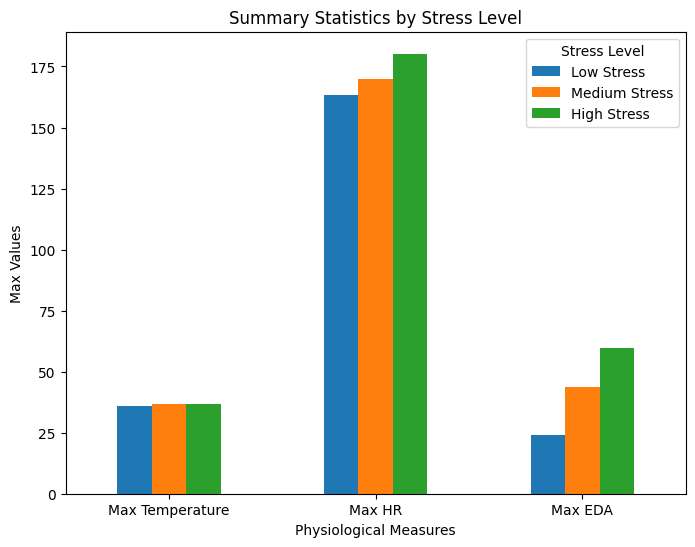

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

# Group data by stress level and calculate summary statistics for maximum temperature, HR, and EDA
temp_summary = df.groupby("label")["TEMP"].max().describe()
hr_summary = df.groupby("label")["HR"].max().describe()
eda_summary = df.groupby("label")["EDA"].max().describe()

# Create a dataframe with the summary statistics
summary_df = pd.DataFrame({
    "Low Stress": [temp_summary["min"], hr_summary["min"], eda_summary["min"]],
    "Medium Stress": [temp_summary["50%"], hr_summary["50%"], eda_summary["50%"]],
    "High Stress": [temp_summary["max"], hr_summary["max"], eda_summary["max"]]
}, index=["Max Temperature", "Max HR", "Max EDA"])

# Plot the summary table as a bar plot
ax = summary_df.plot(kind="bar", figsize=(8, 6), rot=0)

# Set plot attributes
ax.set_xlabel("Physiological Measures")
ax.set_ylabel("Max Values")
ax.set_title("Summary Statistics by Stress Level")
ax.legend(title="Stress Level")

In [35]:
df.datetime

,datetime
0,2020-07-08 14:03:00.000000000
1,2020-07-08 14:03:00.031249920
2,2020-07-08 14:03:00.062500096
3,2020-07-08 14:03:00.093750016
4,2020-07-08 14:03:00.124999936
...,...
11509046,2020-07-23 17:28:59.875000064
11509047,2020-07-23 17:28:59.906249984
11509048,2020-07-23 17:28:59.937499904
11509049,2020-07-23 17:28:59.968750080


In [34]:
df.nunique()

,0
X,256
Y,256
Z,256
EDA,274452
HR,6268
TEMP,599
id,18
datetime,10628304
label,3


In [36]:
# Extract datetime features
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['hour'] = df['datetime'].dt.hour
df['minute'] = df['datetime'].dt.minute
df['second'] = df['datetime'].dt.second

<ipython-input-37-a2b9352c5d7f>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['X'])


<Axes: xlabel='X', ylabel='Density'>

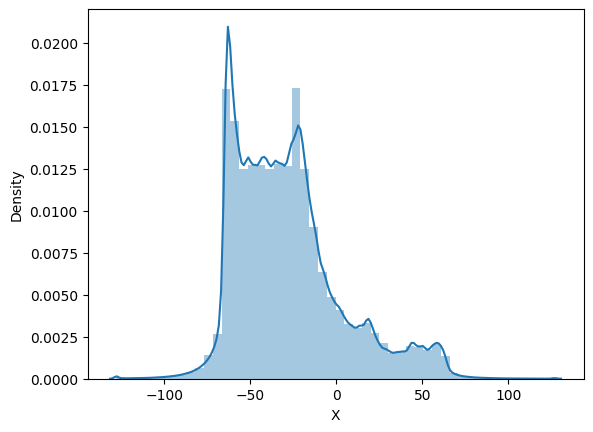

In [37]:
sns.distplot(df['X'])

<ipython-input-38-872cac5ad94b>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Y'])


<Axes: xlabel='Y', ylabel='Density'>

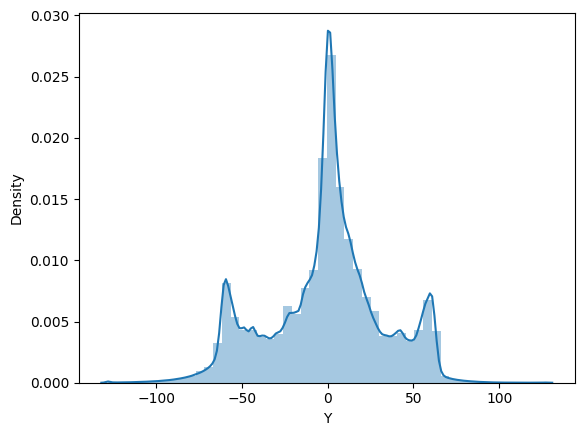

In [38]:
sns.distplot(df['Y'])

<ipython-input-39-35d55cf5293c>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['EDA'])


<Axes: xlabel='EDA', ylabel='Density'>

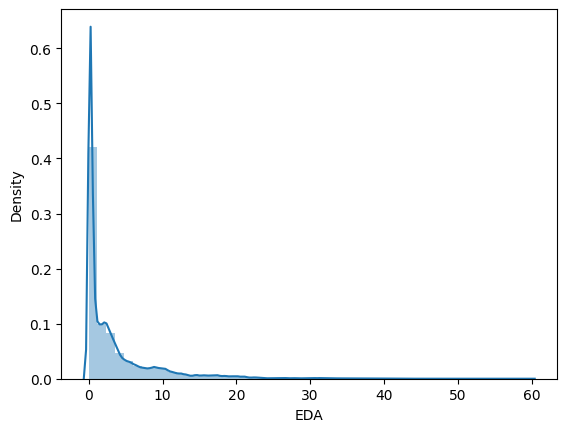

In [39]:
sns.distplot(df['EDA'])

<ipython-input-40-7a31c5f1f151>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['HR'])


<Axes: xlabel='HR', ylabel='Density'>

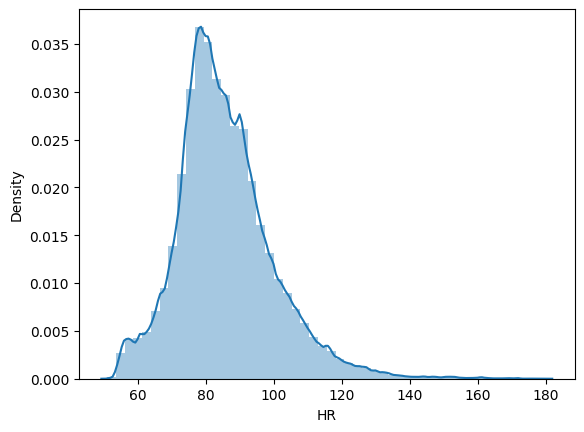

In [40]:
sns.distplot(df['HR'])

<ipython-input-41-adc904bfd6a8>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['TEMP'])


<Axes: xlabel='TEMP', ylabel='Density'>

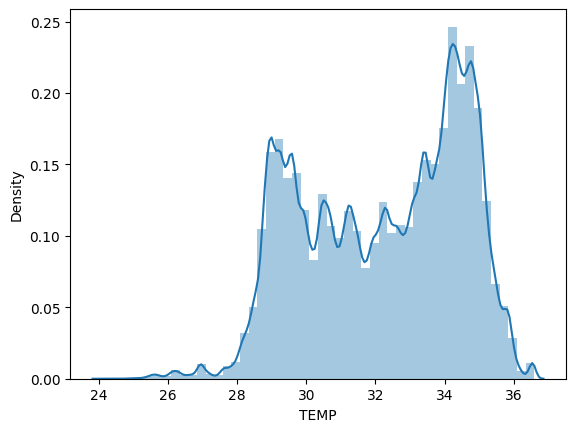

In [41]:
sns.distplot(df['TEMP'])

In [42]:
df['label'].value_counts()

,count
label,
2.0,8540583
0.0,2162246
1.0,806222


Text(0, 0.5, 'Frequency')

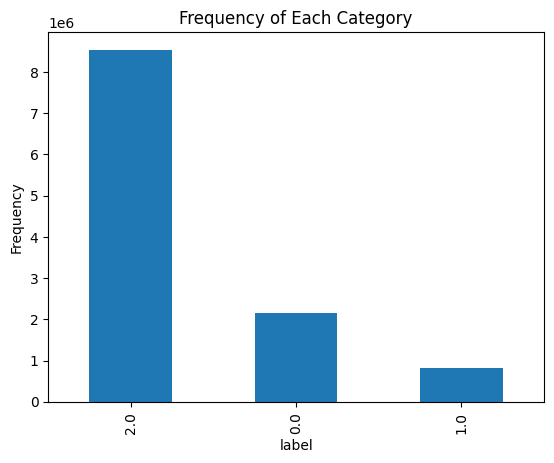

In [43]:
df['label'].value_counts().plot(kind='bar')
plt.title('Frequency of Each Category')
plt.ylabel('Frequency')

<Axes: xlabel='X', ylabel='Count'>

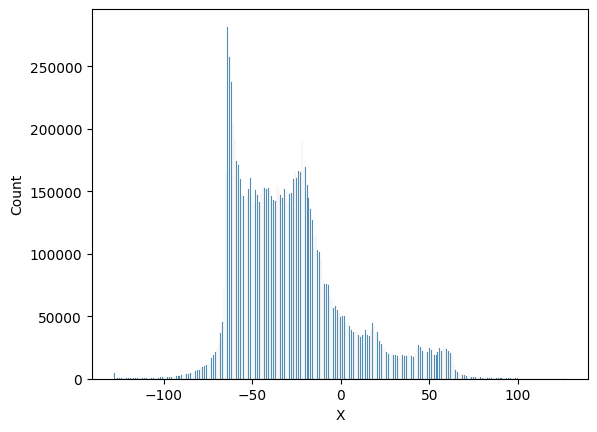

In [45]:

sns.histplot(df['X'])

<Axes: xlabel='Y', ylabel='Count'>

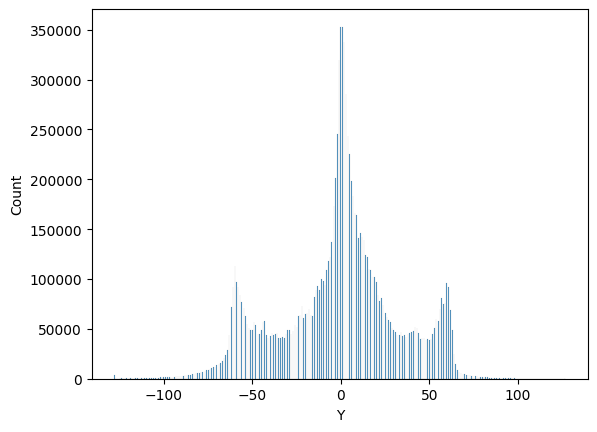

In [46]:

sns.histplot(df['Y'])

<Axes: xlabel='Z', ylabel='Count'>

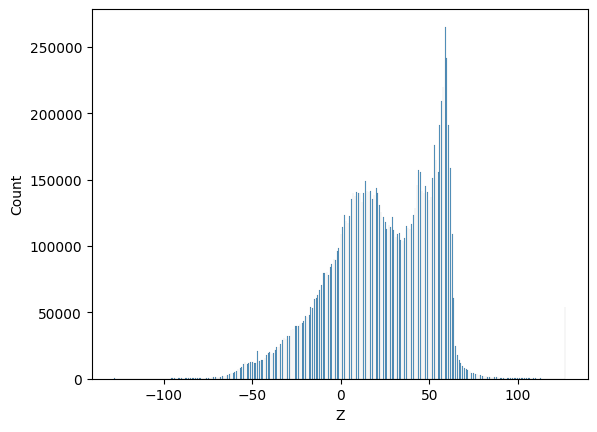

In [47]:

sns.histplot(df['Z'])

<Axes: xlabel='EDA', ylabel='Count'>

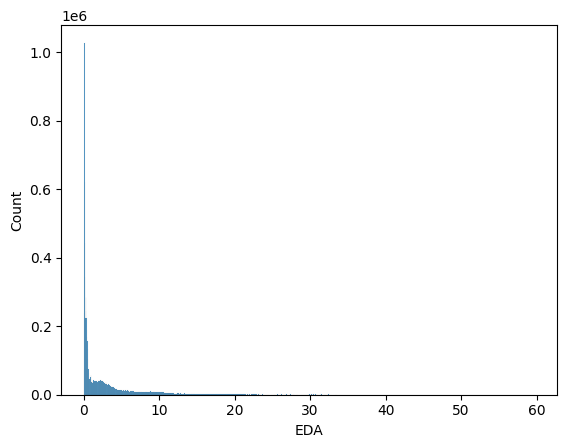

In [48]:
sns.histplot(df['EDA'])

In [50]:
import seaborn as sns

In [51]:
df.drop('id',axis=1,inplace=True)

In [52]:
# Correlation matrix
corr_mat = df.corr().round(2)
# Correlation matrix
corr_mat

,X,Y,Z,EDA,HR,TEMP,datetime,label,month,day,hour,minute,second
X,1.00,0.07,0.20,0.09,0.13,0.02,0.11,-0.01,0.12,-0.15,0.11,-0.00,0.0
Y,0.07,1.00,0.02,-0.10,-0.07,-0.08,-0.07,-0.02,-0.07,0.05,0.16,-0.03,-0.0
Z,0.20,0.02,1.00,0.01,-0.10,-0.03,-0.05,-0.06,-0.05,-0.03,0.07,0.02,0.0
EDA,0.09,-0.10,0.01,1.00,0.14,0.35,-0.11,0.05,-0.10,0.02,-0.10,0.03,-0.0
HR,0.13,-0.07,-0.10,0.14,1.00,0.16,0.04,-0.03,0.03,0.09,-0.06,-0.00,-0.0
TEMP,0.02,-0.08,-0.03,0.35,0.16,1.00,0.18,0.14,0.19,-0.12,-0.25,-0.01,-0.0
datetime,0.11,-0.07,-0.05,-0.11,0.04,0.18,1.00,0.15,0.99,-0.34,-0.61,-0.00,-0.0
label,-0.01,-0.02,-0.06,0.05,-0.03,0.14,0.15,1.00,0.15,-0.08,-0.26,-0.02,-0.0
month,0.12,-0.07,-0.05,-0.10,0.03,0.19,0.99,0.15,1.00,-0.45,-0.60,-0.01,-0.0
day,-0.15,0.05,-0.03,0.02,0.09,-0.12,-0.34,-0.08,-0.45,1.00,0.16,0.04,0.0


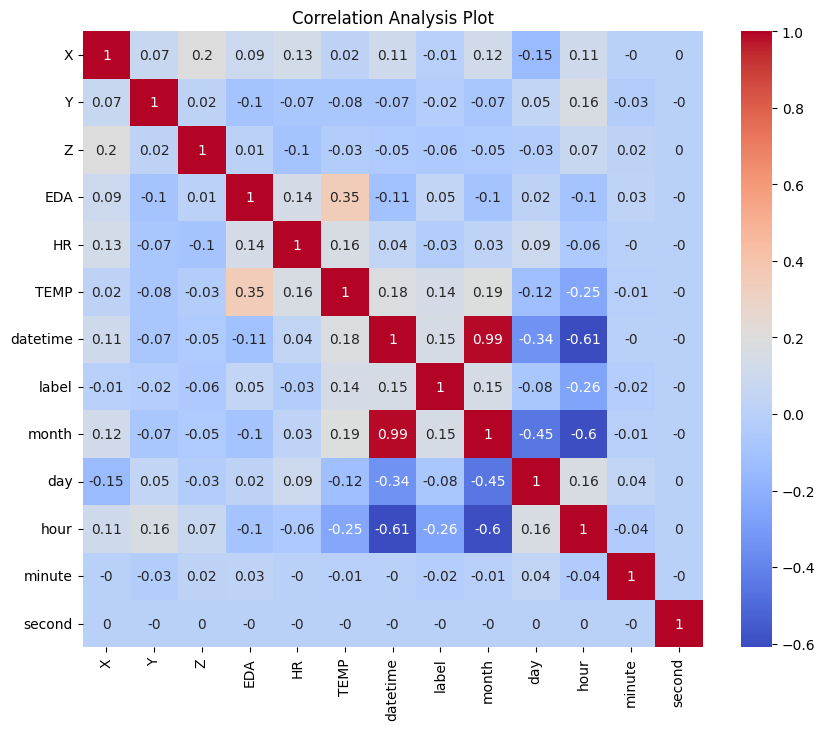

In [53]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_mat, annot=True, cmap='coolwarm')
plt.title('Correlation Analysis Plot')
plt.show()

In [54]:
corr_mat['label']

,label
X,-0.01
Y,-0.02
Z,-0.06
EDA,0.05
HR,-0.03
TEMP,0.14
datetime,0.15
label,1.00
month,0.15
day,-0.08


EDA

In [ ]:
print('data')
display(df.isnull().sum())

plt.figure(figsize = (4, 2))
plt.title("Training Set")
sns.heatmap(df.isnull())
plt.show()

data


,0
X,0
Y,0
Z,0
EDA,0
HR,0
TEMP,0
datetime,0
label,0
month,0
day,0


In [4]:
import pandas as pdd

In [5]:
train = pdd.read_csv('/kaggle/input/nurse-stress-prediction-wearable-sensors/merged_data.csv')
display(train)

<ipython-input-5-945687913836>:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pdd.read_csv('/kaggle/input/nurse-stress-prediction-wearable-sensors/merged_data.csv')


,X,Y,Z,EDA,HR,TEMP,id,datetime,label
0,-13.0,-61.0,5.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.000000000,2.0
1,-20.0,-69.0,-3.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.031249920,2.0
2,-31.0,-78.0,-15.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.062500096,2.0
3,-47.0,-65.0,-38.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.093750016,2.0
4,-67.0,-57.0,-53.0,6.769995,99.43,31.17,15,2020-07-08 14:03:00.124999936,2.0
...,...,...,...,...,...,...,...,...,...
11509046,-16.0,-56.0,24.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.875000064,2.0
11509047,-8.0,-50.0,27.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.906249984,2.0
11509048,-28.0,-36.0,28.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.937499904,2.0
11509049,-29.0,-29.0,30.0,3.386070,88.37,33.77,F5,2020-07-23 17:28:59.968750080,2.0


In [6]:
train= train.drop(columns=['id'],axis=1)
train

,X,Y,Z,EDA,HR,TEMP,datetime,label
0,-13.0,-61.0,5.0,6.769995,99.43,31.17,2020-07-08 14:03:00.000000000,2.0
1,-20.0,-69.0,-3.0,6.769995,99.43,31.17,2020-07-08 14:03:00.031249920,2.0
2,-31.0,-78.0,-15.0,6.769995,99.43,31.17,2020-07-08 14:03:00.062500096,2.0
3,-47.0,-65.0,-38.0,6.769995,99.43,31.17,2020-07-08 14:03:00.093750016,2.0
4,-67.0,-57.0,-53.0,6.769995,99.43,31.17,2020-07-08 14:03:00.124999936,2.0
...,...,...,...,...,...,...,...,...
11509046,-16.0,-56.0,24.0,3.386070,88.37,33.77,2020-07-23 17:28:59.875000064,2.0
11509047,-8.0,-50.0,27.0,3.386070,88.37,33.77,2020-07-23 17:28:59.906249984,2.0
11509048,-28.0,-36.0,28.0,3.386070,88.37,33.77,2020-07-23 17:28:59.937499904,2.0
11509049,-29.0,-29.0,30.0,3.386070,88.37,33.77,2020-07-23 17:28:59.968750080,2.0


In [7]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train['datetime'] = le.fit_transform(train['datetime'])
display(train)

,X,Y,Z,EDA,HR,TEMP,datetime,label
0,-13.0,-61.0,5.0,6.769995,99.43,31.17,5330929,2.0
1,-20.0,-69.0,-3.0,6.769995,99.43,31.17,5330930,2.0
2,-31.0,-78.0,-15.0,6.769995,99.43,31.17,5330931,2.0
3,-47.0,-65.0,-38.0,6.769995,99.43,31.17,5330932,2.0
4,-67.0,-57.0,-53.0,6.769995,99.43,31.17,5330933,2.0
...,...,...,...,...,...,...,...,...
11509046,-16.0,-56.0,24.0,3.386070,88.37,33.77,7337366,2.0
11509047,-8.0,-50.0,27.0,3.386070,88.37,33.77,7337367,2.0
11509048,-28.0,-36.0,28.0,3.386070,88.37,33.77,7337368,2.0
11509049,-29.0,-29.0,30.0,3.386070,88.37,33.77,7337369,2.0


In [9]:
import matplotlib.pyplot as plt

In [11]:
import seaborn as sns

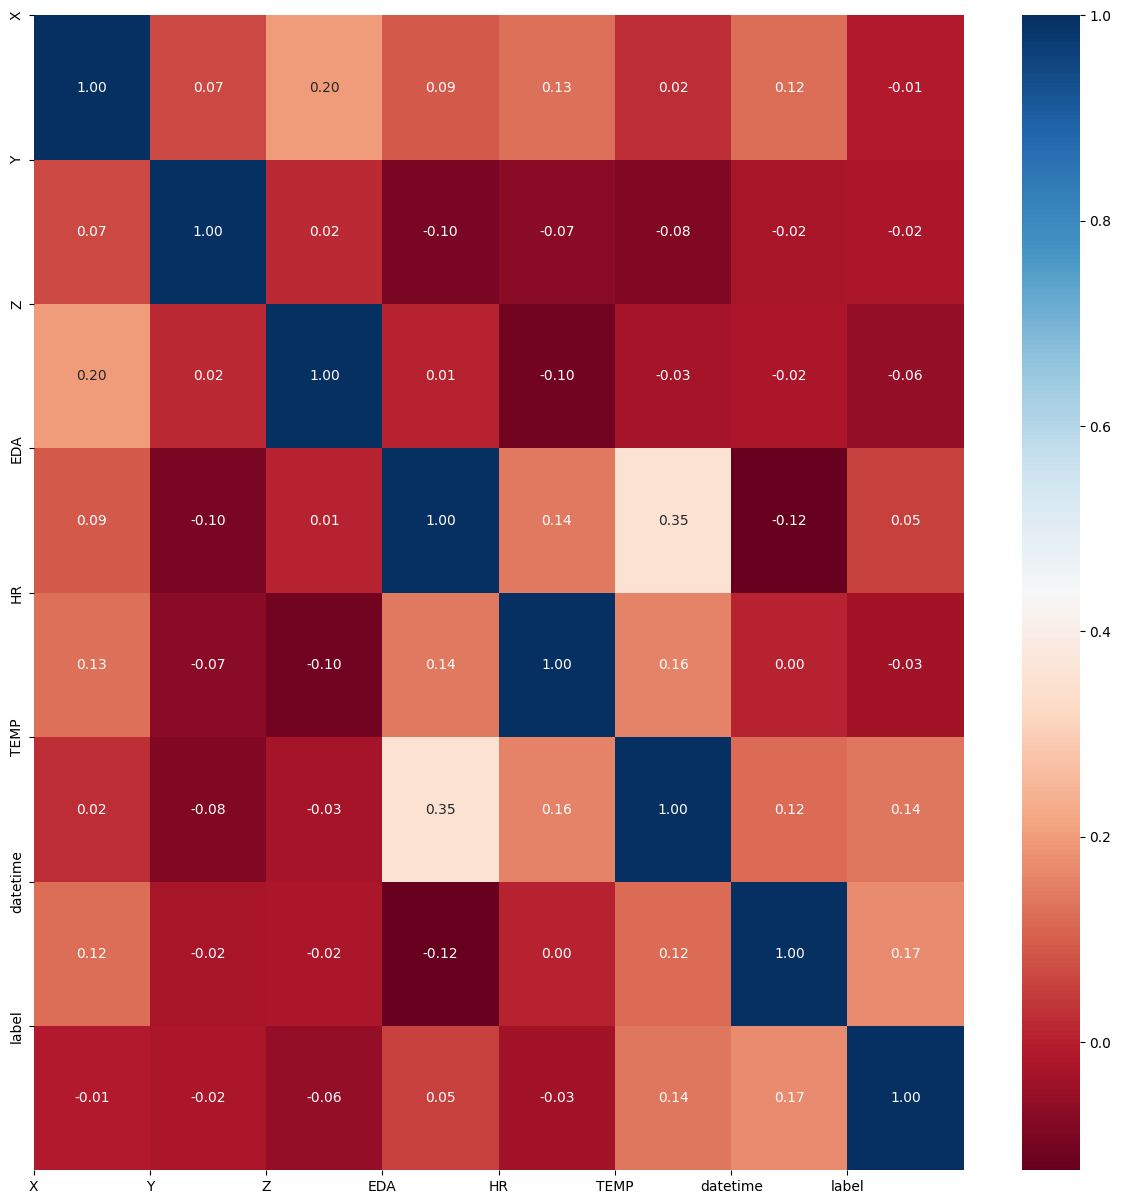

In [12]:
corr = train.corr(method='pearson')
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corr, cmap='RdBu', annot=True, fmt=".2f")
plt.xticks(range(len(corr.columns)), corr.columns);
plt.yticks(range(len(corr.columns)), corr.columns)
plt.show()